In [ ]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
from adjustText import adjust_text
import warnings



# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")


In [ ]:
def phateumap(X,plot=None,recalculate=False,save=None,title=None,bbknn=True,cluster='batch',cmap=None) :
    """Plot or recalculate then plot
    
    Args:
        X (AnnData): subsetted AnnData object
        plot (ax object): optional. give ax object to plot in multiple for loop 
        save (str): optional. Save the plot with the full filepath indicated, otherwise return ax
    """
    if recalculate :
        # umap/louvain based off batch-balanced graph
        sc.tl.pca(X,n_comps=100)
        if bbknn:
            sc.external.pp.bbknn(X,batch_key='batch')
        else :
            sc.pp.neighbors(X,n_neighbors=30,n_pcs=100)
        sc.tl.umap(X)
        sc.tl.louvain(X,resolution=0.5)

        # compute PHATE
        G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None

        phate_op = phate.PHATE(knn_dist='precomputed',
                               gamma=0,
                               n_jobs=-1)
        X.obsm['X_phate']=phate_op.fit_transform(G.K)
        
    if plot is not None :
        if not isinstance(plot,plt.Axes) :
            fig,ax=plt.subplots(1,2,figsize=(8,3))
        else :
            ax = plot
            
        if cluster=='louvain' :
            color = X.obs[cluster].astype(int)
        else :
            color = X.obs[cluster]
            
        if cmap is None :
            if cluster=='louvain':
                cmap = sns.color_palette('colorblind',len(X.obs[cluster].unique()))
                cmap = {v:cmap[i] for i,v in enumerate(np.unique(X.obs[cluster].astype(int)))}
            cmap = sns.color_palette('colorblind',len(X.obs['batch'].unique())) # problematic if n_batch > 12
            
        # pt_size 
#         s = 10*X.shape[0]*4.8602673147023086e-06 # based on s=0.2 for N=hdata.shape[0]

            
        scprep.plot.scatter2d(X.obsm['X_umap'],
                      c=color,
                      cmap=cmap,
                      ticks=None,
                      label_prefix='UMAP',
                      legend=False,
                      ax=ax[0],
#                       s = s,
                      alpha=0.6,
                      title=title,
                      rasterized=True)
        scprep.plot.scatter2d(X.obsm['X_phate'],
                              c=color,
                              cmap=cmap,
                              ticks=None,
                              label_prefix='PHATE',
                              legend=True,
                              legend_loc=(1.01,0.1),
                              ax=ax[1],
#                               s = s,
                              alpha=0.6,
                              title=title,
                              rasterized=True)
        if save is not None :
            if '.pdf' in save :
                fig.savefig(save,dpi=300, bbox_inches='tight')
            else : 
                fig.savefig(save+'.pdf',dpi=300, bbox_inches='tight')
                
    return X 

        

In [3]:

# fps
dfp = '/home/ngr4/project/scnd/data/'
pfp = '/home/ngr4/project/scnd/results/'
pdfp = '/home/ngr4/project/scnd/data/processed/'
sc.settings.figdir = pfp

def loader(fname,fpath,backed=None) : 
    start = time.time()
    adata = sc.read_h5ad(filename=os.path.join(fpath,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    return adata

def writer(fname,fpath,AnnData) :
    start = time.time()
    Anndata.write(os.path.join(fpath,fname))
    print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to save data'.format(time.time()-start))
    

if True :
    # load human
    fname='hum_MT_bbknn.h5ad'
    %memit hdata = loader(fname,pdfp)
    
if False :
    # load mouse
    fname='mouse_MT_bbknn.h5ad'
    %memit mdata = loader(fname,pdfp)


loaded @200408.23:33:24
took 44.38-s to load data
peak memory: 20561.85 MiB, increment: 20359.16 MiB


In [4]:
# reduce size of data
hdata

AnnData object with n_obs × n_vars = 41150 × 27783 
    obs: 'batch', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'ctype'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'ctype_colors', 'dendrogram_louvain', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_bbknn'

In [5]:
# read in looms
## point to directory where ./sample1 ./sample2, etc. exists and ./sample/*loom exists
loom_fpath = '/home/ngr4/project/scnd/data/human/'
loom_files = glob.glob(os.path.join(loom_fpath,'*/*.loom'))
sample_names = [os.path.split(os.path.split(loom_files[i])[0])[1] for i in range(len(loom_files))]

adata_looms = {}
for i in range(len(loom_files)):
    start = time.time()
    if i == 0:
        adata_loom = scv.read_loom(loom_files[i],sparse=True,cleanup=True)
    else:
        adata_looms[sample_names[i]] = scv.read_loom(loom_files[i],sparse=True,cleanup=True)
try:
    adata_loom = adata_loom.concatenate(*adata_looms.values(), batch_categories=sample_names)
except ValueError:
    adata_loom = adata_loom.concatenate(*adata_looms.values(), batch_categories=sample_names)
    
if True:
    # merge with existing adata
    adata = scv.utils.merge(hdata, adata_loom)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Making variable names unique for controlled concatenation.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not uniqu

In [6]:
# check 
print(hdata)
print(adata)

AnnData object with n_obs × n_vars = 41150 × 27783 
    obs: 'batch', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'ctype', 'sample_batch'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'ctype_colors', 'dendrogram_louvain', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_bbknn'
AnnData object with n_obs × n_vars = 41150 × 27150 
    obs: 'batch', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_co

In [7]:
adata.obs['genotype']=['SCA1' if 'SCA' in i else 'WT' for i in adata.obs['Sample']]

In [8]:
# subset of cells for velocity analysis
wtt = adata[((adata.obs['ctype']=='Oligodendrocyte') |
           (adata.obs['ctype']=='Oligodendrocyte progenitor cell')) & (adata.obs['genotype']=='WT'),:]
wtt.obs["value"] = 0  # This makes subsetted AnnData a “real” AnnData object

# subset of cells for velocity analysis
scat = adata[((adata.obs['ctype']=='Oligodendrocyte') |
           (adata.obs['ctype']=='Oligodendrocyte progenitor cell')) & (adata.obs['genotype']=='SCA1'),:]
scat.obs["value"] = 0  # This makes subsetted AnnData a “real” AnnData object

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [9]:
wt = sc.AnnData(X=wtt.X, obs=wtt.obs)
sca = sc.AnnData(X=scat.X, obs=scat.obs)

In [10]:
wt.layers['ambiguous']=wtt.layers['ambiguous']
wt.layers['spliced']=wtt.layers['spliced']
wt.layers['unspliced']=wtt.layers['unspliced']
wt.var_names = wtt.var_names

sca.layers['ambiguous']=scat.layers['ambiguous']
sca.layers['spliced']=scat.layers['spliced']
sca.layers['unspliced']=scat.layers['unspliced']
sca.var_names = scat.var_names


In [11]:
scv.pp.moments(wt, n_pcs=30, n_neighbors=30)
scv.pp.moments(sca, n_pcs=30, n_neighbors=30)

Normalized count data: spliced, unspliced.
computing PCA with n_comps = 30
    finished (0:00:01)
computing neighbors
    finished (0:00:05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
Normalized count data: spliced, unspliced.
computing PCA with n_comps = 30
    finished (0:00:01)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [13]:
scv.tl.recover_dynamics(wt)
scv.tl.velocity(wt, mode='dynamical')
scv.tl.velocity_graph(wt)

scv.tl.recover_dynamics(sca)
scv.tl.velocity(sca, mode='dynamical')
scv.tl.velocity_graph(sca)

recovering dynamics
    finished (0:11:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics
    finished (0:10:28) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [14]:
wt = phateumap(wt,plot=None,recalculate=True,save=None,title=None,bbknn=True,cluster='batch',cmap=None)
sca = phateumap(sca,plot=None,recalculate=True,save=None,title=None,bbknn=True,cluster='batch',cmap=None)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:01)
computing batch balanced neighbors
	finished (0:00:02)
computing UMAP
    finished (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1055 cells.
  Calculating graph and diffusion operator...
  Calculating optimal t...
  Calculated optimal t in 0.36 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.10 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.61 seconds.
Calculated PHATE in 10.09 seconds.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reprodu

In [15]:
# X.obsm['X_phate']=x.obsm['X_phate']
# X.obsm['X_umap']=x.obsm['X_umap']

In [16]:
# X.obs['genotype']=['SCA1' if 'SCA' in i else 'CTRL' for i in X.obs['Sample']]

In [17]:
pal18=['#ee5264','#565656','#75a3b7','#ffe79e','#fac18a','#f1815f','#ac5861','#62354f','#2d284b','#f4b9b9','#c4bbaf',
               '#f9ebae','#aecef9','#aeb7f9','#f9aeae','#9c9583','#88bb92','#bde4a7','#d6e5e3']


In [19]:
# for k,v in X.uns.items():
#     if 'color' in k:
#         X.uns[k]=np.array(pal18,dtype=object)

computing velocity clusters
    finished (0:00:00) --> added 
    'velocity_clusters', clusters based on modularity on velocity field (adata.obs)
ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns)


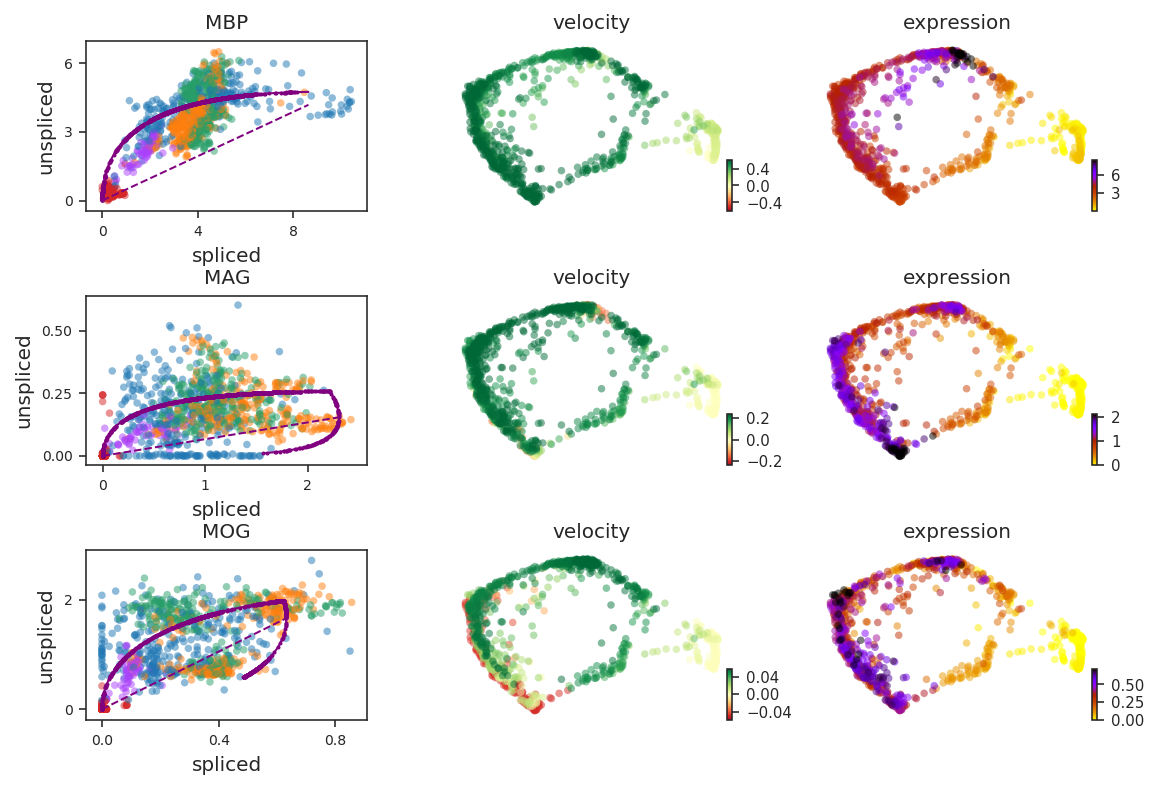

In [20]:
scv.tl.rank_velocity_genes(wt, match_with='ctype')
scv.pl.velocity(wt, var_names=['MBP','MAG','MOG'], basis = 'phate')


computing velocity clusters
    finished (0:00:00) --> added 
    'velocity_clusters', clusters based on modularity on velocity field (adata.obs)
ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns)


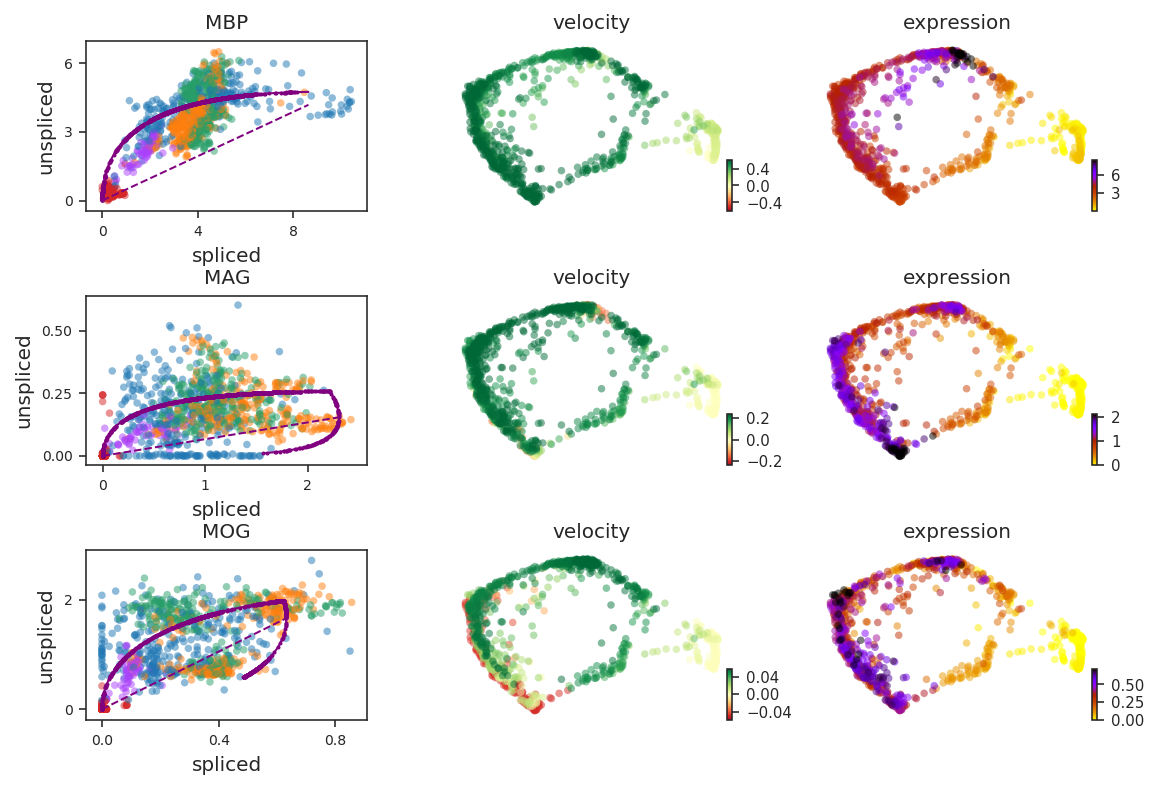

In [21]:
scv.tl.rank_velocity_genes(wt, match_with='ctype')
scv.pl.velocity(wt, var_names=['MBP','MAG','MOG'], basis = 'phate')


329
computing latent time
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


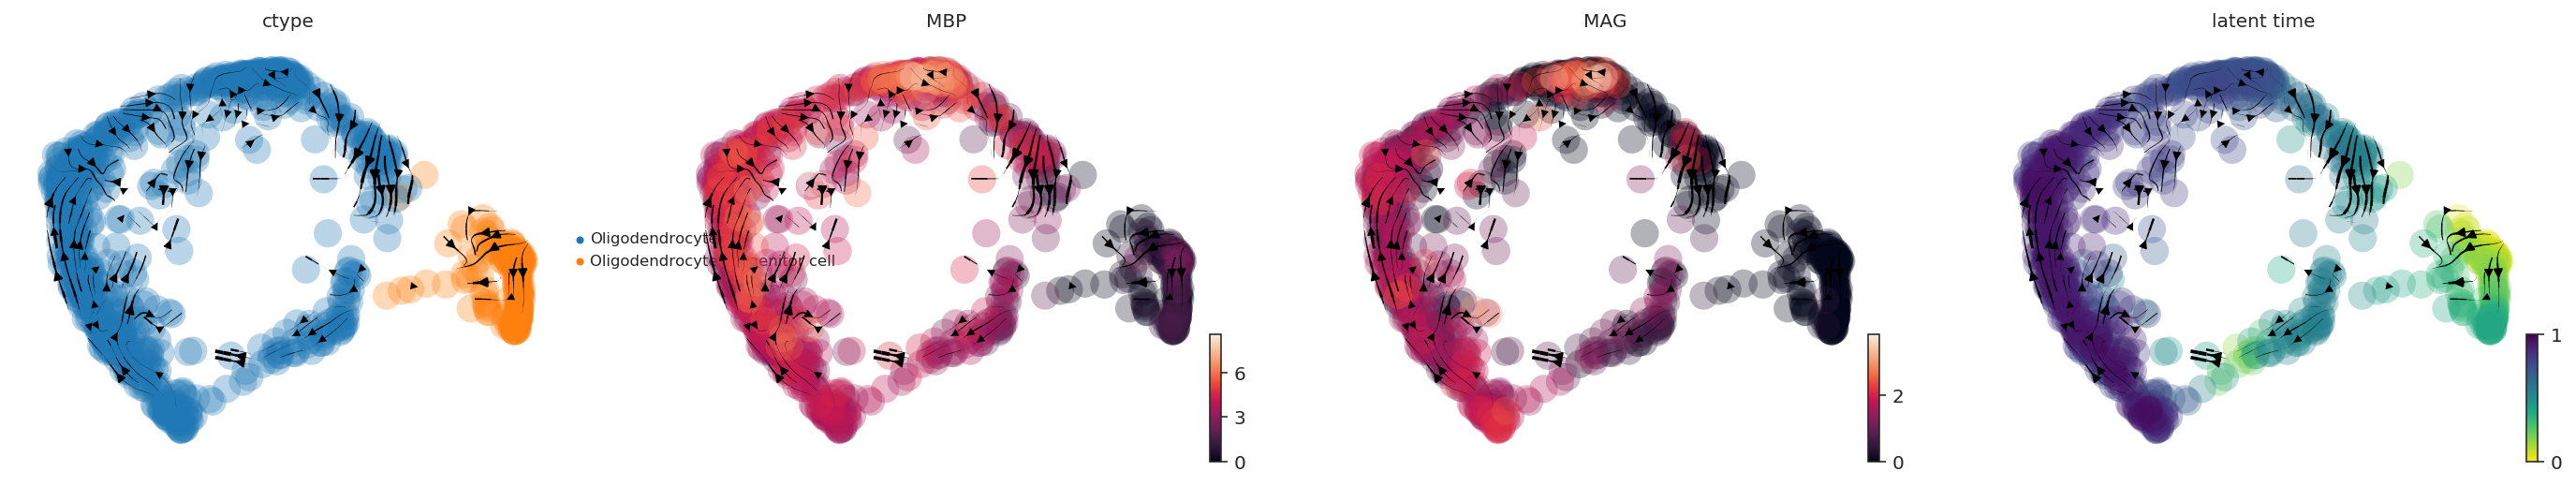

In [69]:
# with root
if False: 
    # random
    idx = np.where(wt.obs['ctype']=='Oligodendrocyte progenitor cell')[0]
    wt.obs['root']=False
    wt.obs['root'][np.random.choice(idx)]=True
    wt.uns['root']=np.where(wt.obs['root'])[0][0]
    scv.tl.recover_latent_time(wt,root_key='root')
    scv.pl.velocity_embedding_stream(wt, basis='phate', color=['ctype','MBP','MAG', 'latent_time'], legend_loc='right_margin')
elif True:
    # with max(sum(PDGFRA normed expression))
    idx = np.where(wt.obs['ctype']=='Oligodendrocyte progenitor cell')[0]
    idx = idx[np.argmax(wt[:,['PDGFRA']].X[idx])]
    wt.obs['root']=False
    wt.obs['root'][idx]=True
    print(np.where(wt.obs['root'])[0][0])
    wt.uns['root']=np.where(wt.obs['root'])[0][0]
    scv.tl.recover_latent_time(wt,root_key='root')
    scv.pl.velocity_embedding_stream(wt, basis='phate', color=['ctype','MBP','MAG', 'latent_time'], legend_loc='right_margin')
else:
    # with max(sum(PDGFRA, OLIG1, OLIG2 normed expression))
    idx = np.where(wt.obs['ctype']=='Oligodendrocyte progenitor cell')[0]
    idx = idx[np.argmax(wt[:,['PDGFRA','OLIG1','OLIG2']].X.todense()[idx,:].sum(axis=1))]
    wt.obs['root']=False
    wt.obs['root'][idx]=True
    print(np.where(wt.obs['root'])[0][0])
    wt.uns['root']=np.where(wt.obs['root'])[0][0]
    scv.tl.recover_latent_time(wt,root_key='root')
    scv.pl.velocity_embedding_stream(wt, basis='phate', color=['ctype','MBP','MAG', 'latent_time'], legend_loc='right_margin')


536
computing latent time
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


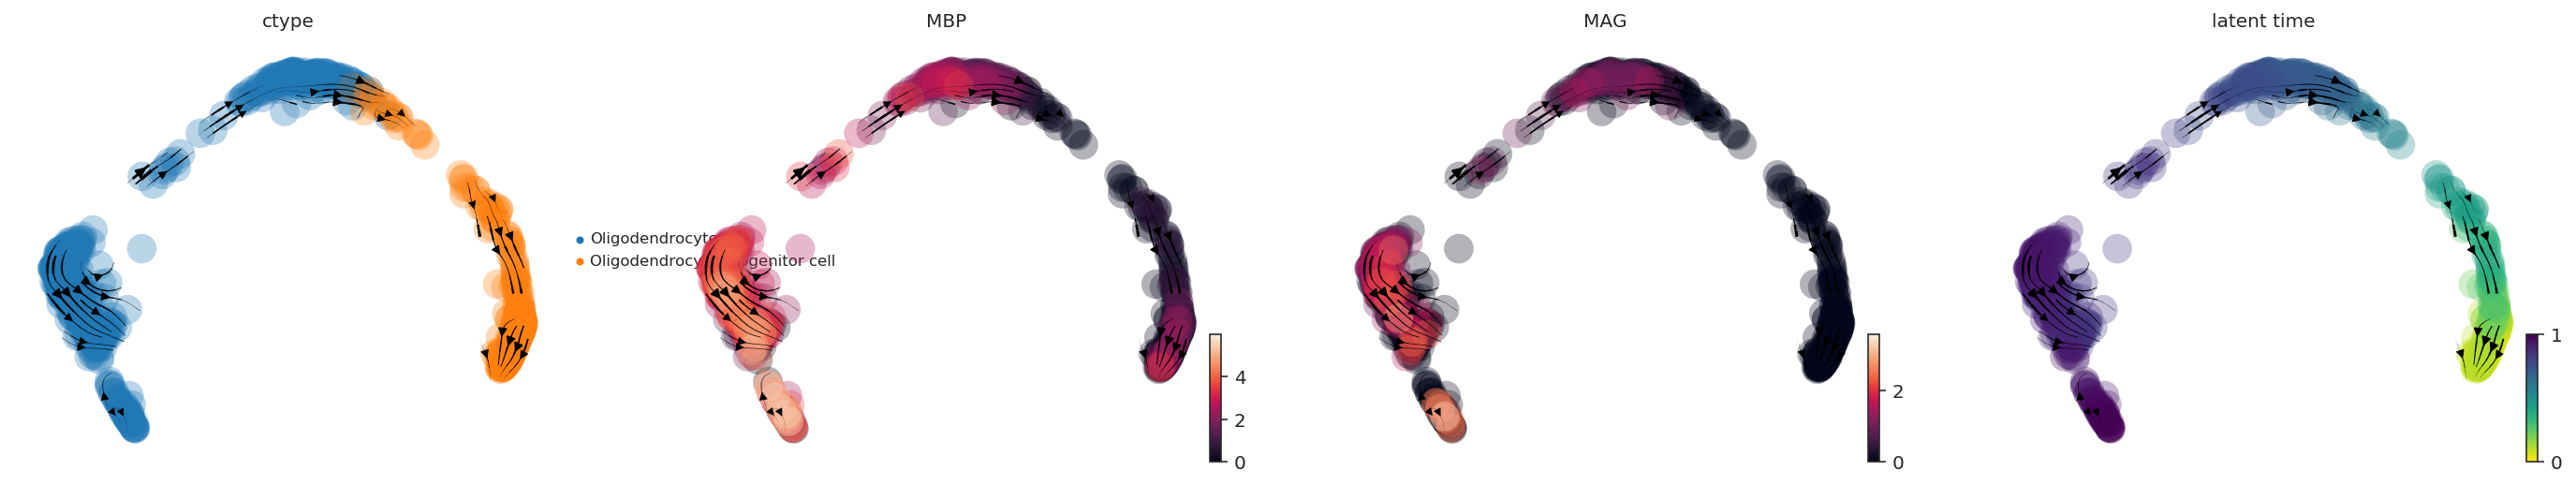

In [68]:
# with root
if False: 
    # random
    idx = np.where(sca.obs['ctype']=='Oligodendrocyte progenitor cell')[0]
    sca.obs['root']=False
    sca.obs['root'][np.random.choice(idx)]=True
    sca.uns['root']=np.where(sca.obs['root'])[0][0]
    scv.tl.recover_latent_time(sca,root_key='root')
    scv.pl.velocity_embedding_stream(sca, basis='phate', color=['ctype','MBP','MAG', 'latent_time'], legend_loc='right_margin')
elif True:
    # with max(sum(PDGFRA normed expression))
    idx = np.where(sca.obs['ctype']=='Oligodendrocyte progenitor cell')[0]
    idx = idx[np.argmax(sca[:,['PDGFRA']].X[idx])]
    sca.obs['root']=False
    sca.obs['root'][idx]=True
    print(np.where(sca.obs['root'])[0][0])
    sca.uns['root']=np.where(sca.obs['root'])[0][0]
    scv.tl.recover_latent_time(sca,root_key='root')
    scv.pl.velocity_embedding_stream(sca, basis='phate', color=['ctype','MBP','MAG', 'latent_time'], legend_loc='right_margin')
else:
    # with max(sum(PDGFRA, OLIG1, OLIG2 normed expression))
    idx = np.where(sca.obs['ctype']=='Oligodendrocyte progenitor cell')[0]
    idx = idx[np.argmax(sca[:,['PDGFRA','OLIG1','OLIG2']].X.todense()[idx,:].sum(axis=1))]
    sca.obs['root']=False
    sca.obs['root'][idx]=True
    print(np.where(sca.obs['root'])[0][0])
    sca.uns['root']=np.where(sca.obs['root'])[0][0]
    scv.tl.recover_latent_time(sca,root_key='root')
    scv.pl.velocity_embedding_stream(sca, basis='phate', color=['ctype','MBP','MAG', 'latent_time'], legend_loc='right_margin')


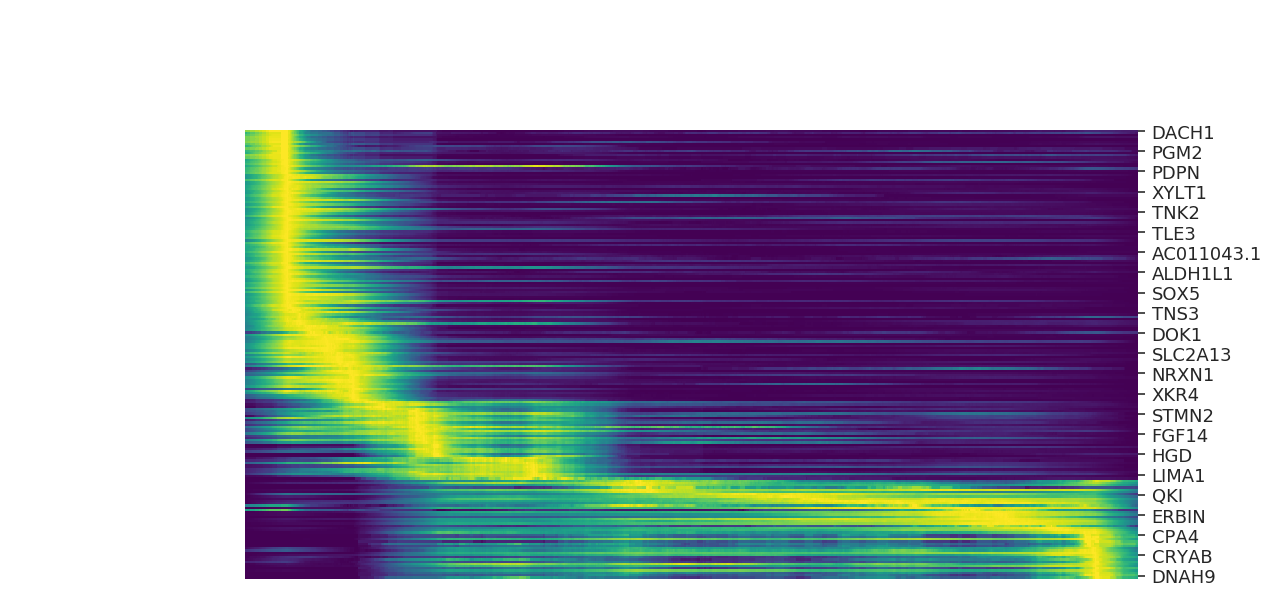

In [24]:
top_genes = wt.var_names[wt.var.fit_likelihood.argsort()[::-1]][:200]
scv.pl.heatmap(wt, var_names=top_genes, tkey='latent_time', n_convolve=100)


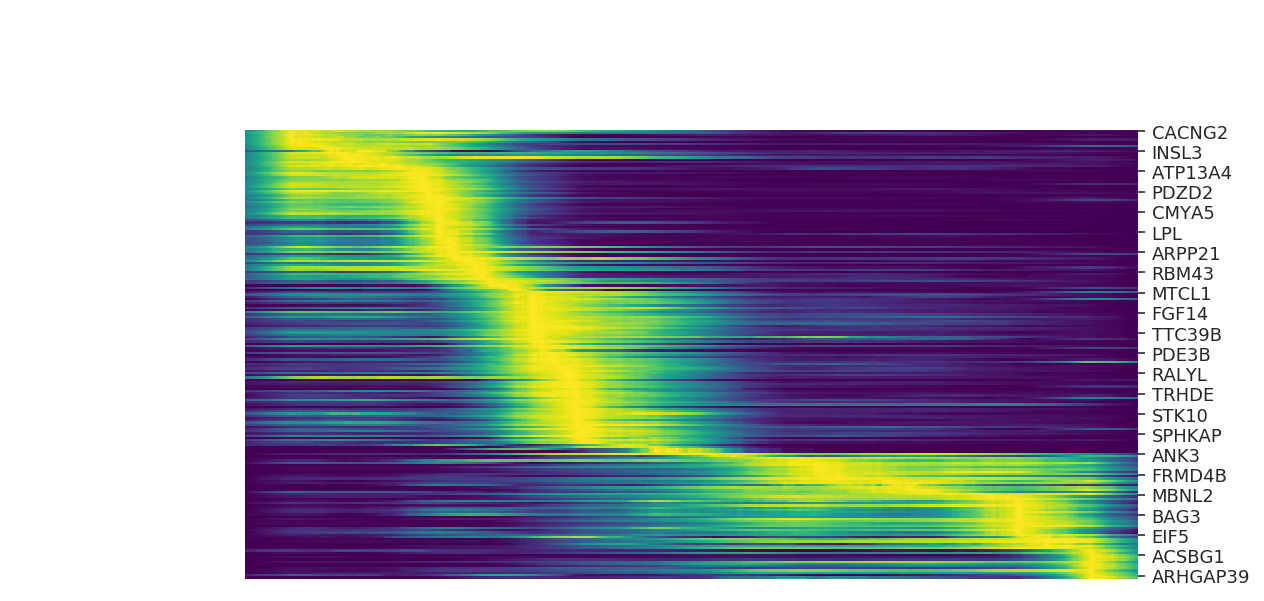

In [25]:
top_genes = sca.var_names[sca.var.fit_likelihood.argsort()[::-1]][:200]
scv.pl.heatmap(sca, var_names=top_genes, tkey='latent_time', n_convolve=100)


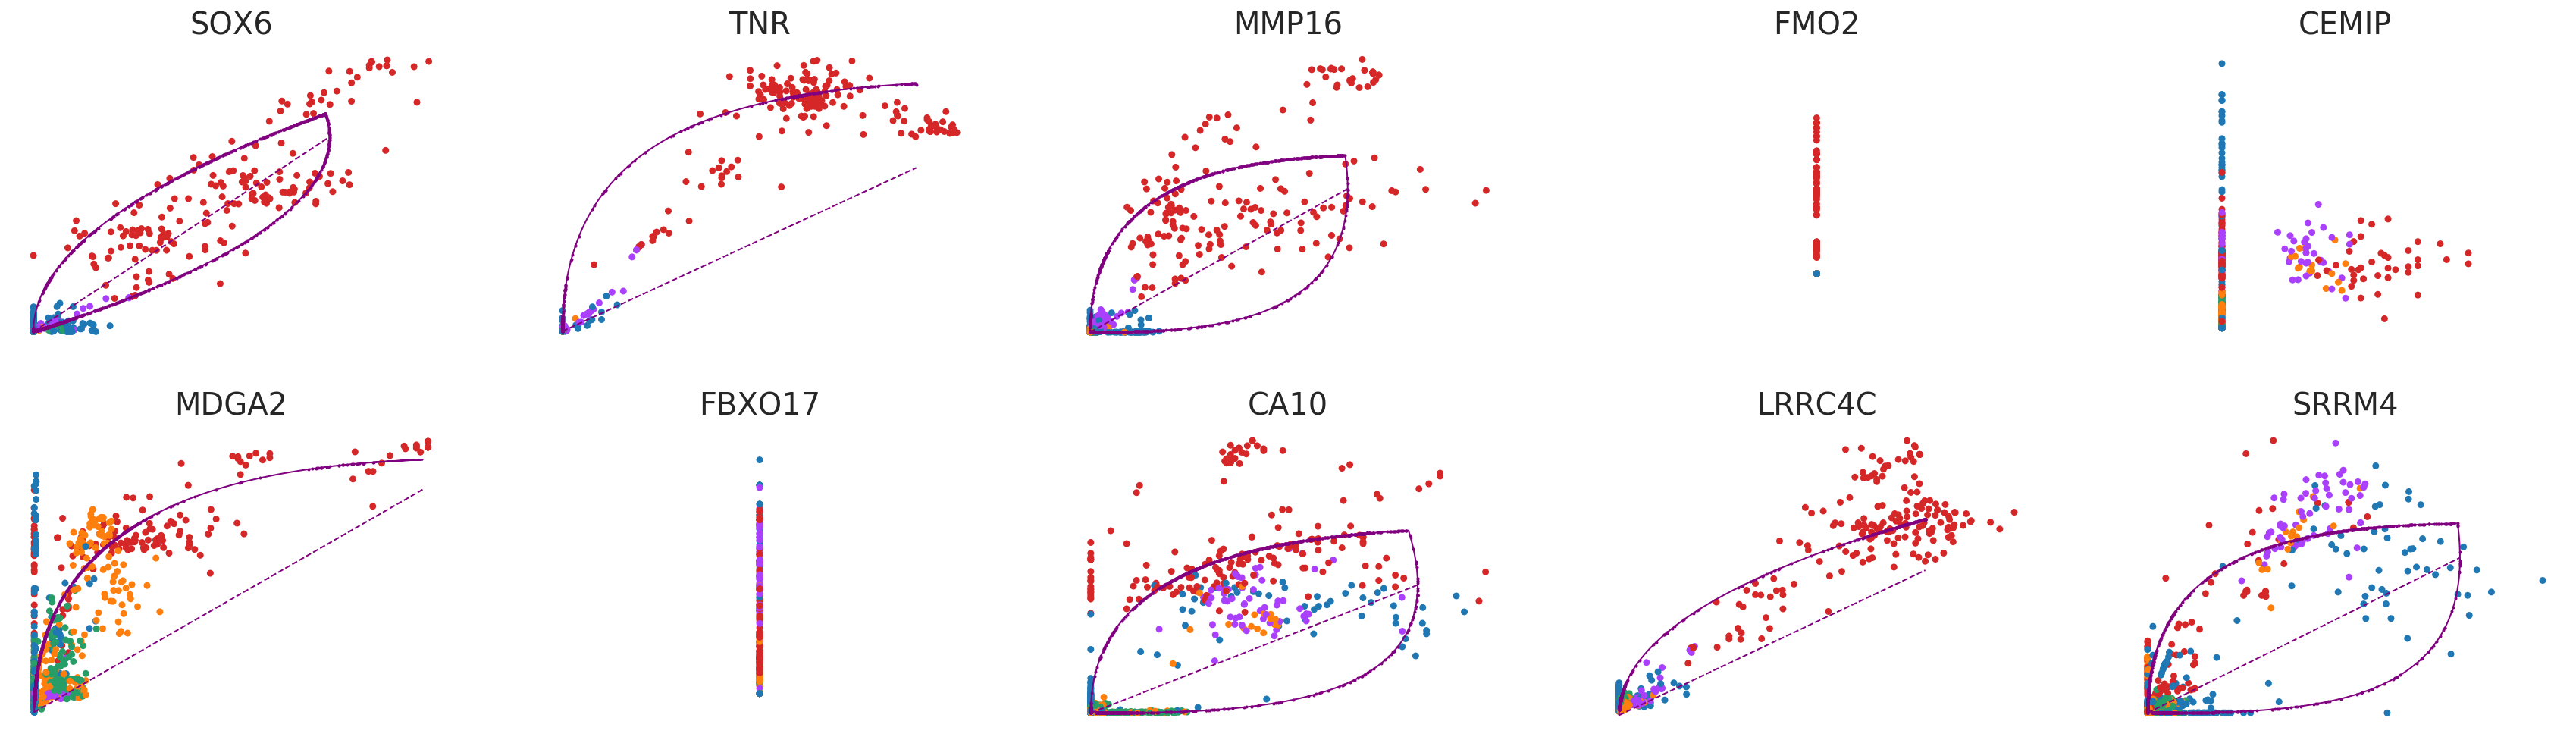

In [26]:
scv.pl.scatter(wt, basis=top_genes[:10], legend_loc='none',
               size=80, frameon=False, ncols=5, fontsize=20)

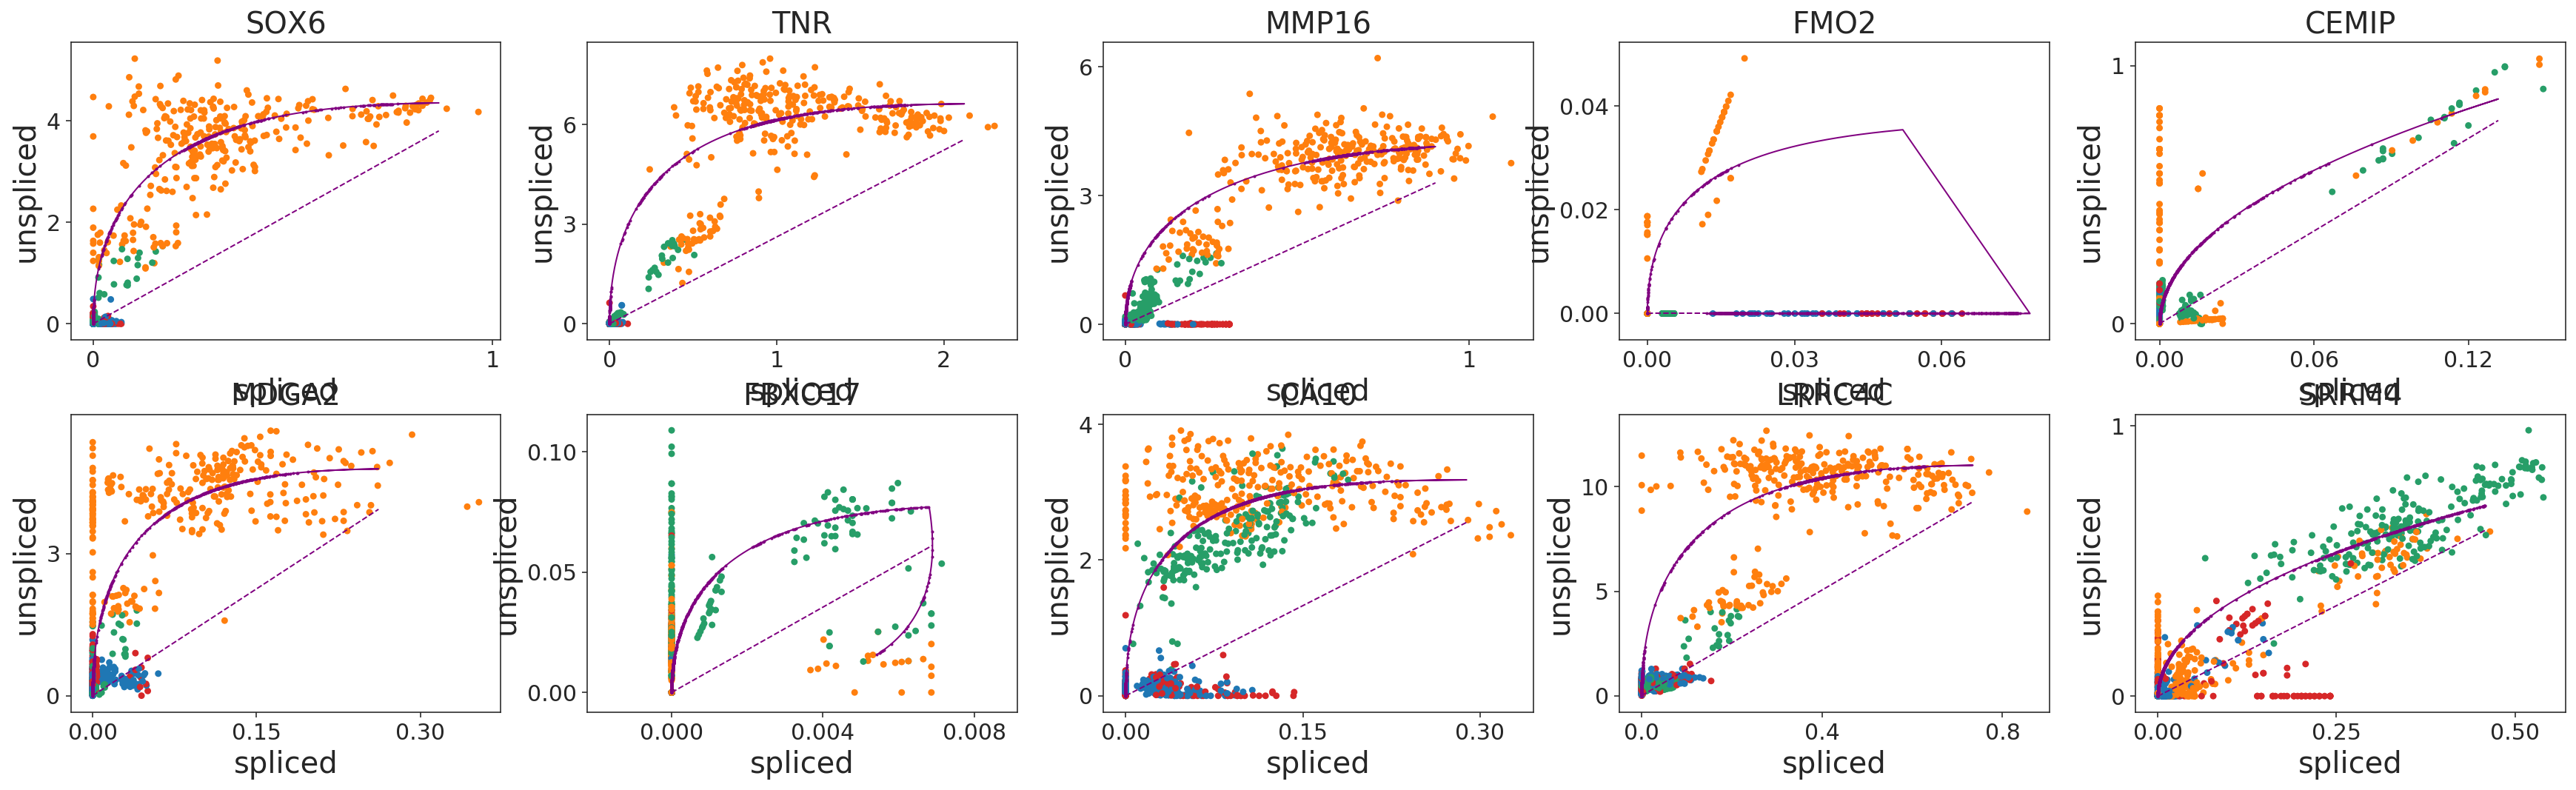

In [32]:
scv.pl.scatter(sca, basis=top_genes[:10], legend_loc='none',
               size=80, frameon=True, ncols=5, fontsize=20)

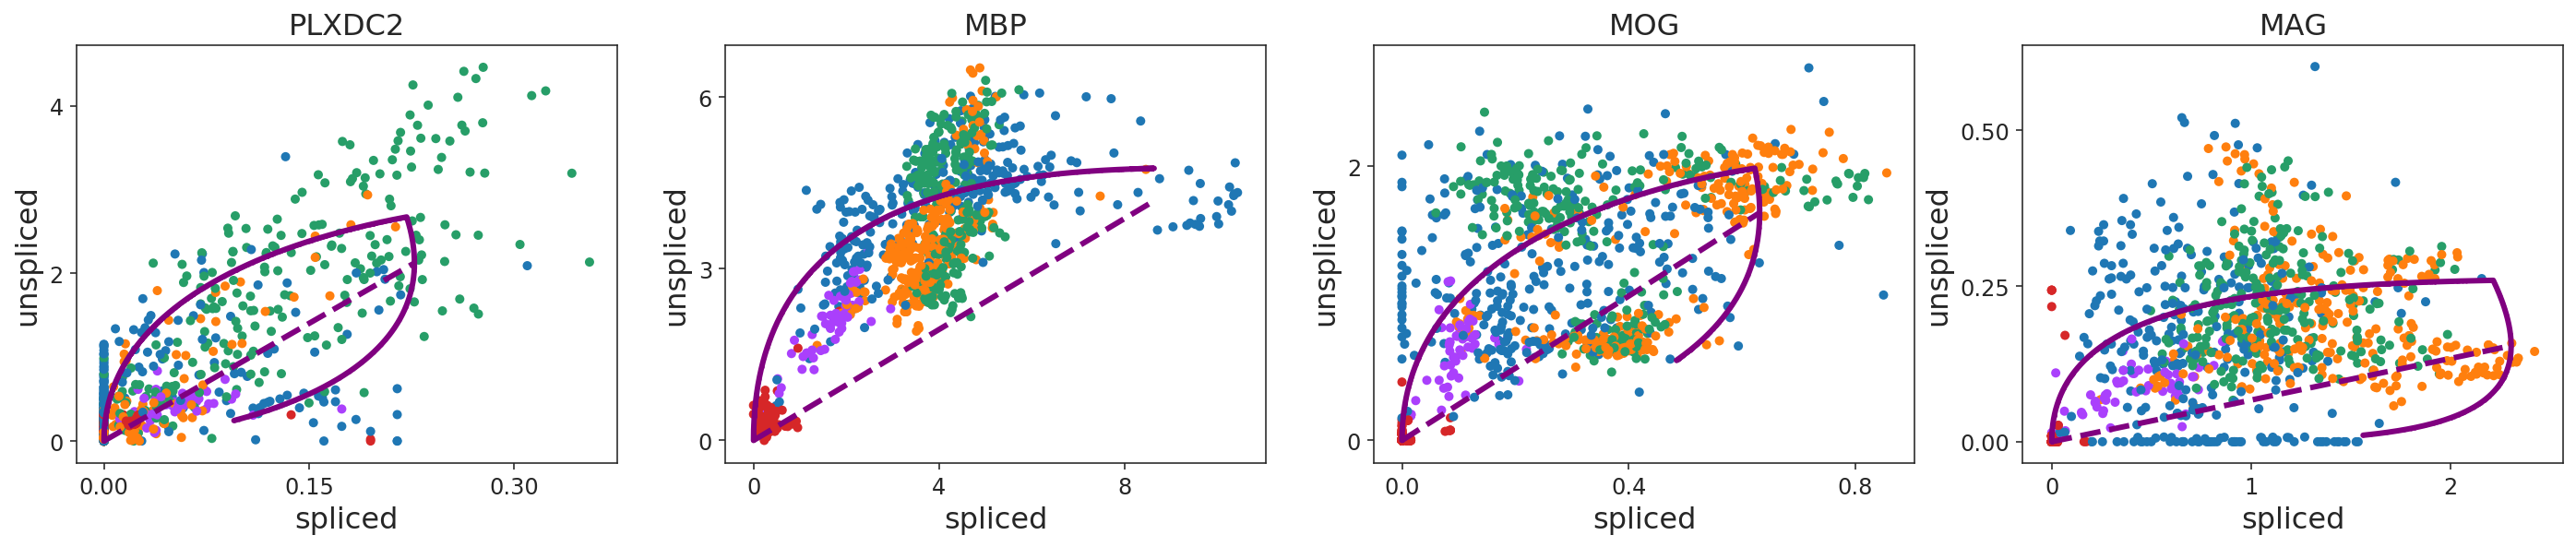

In [28]:
scv.pl.scatter(wt, basis=['PLXDC2', 'MBP', 'MOG', 'MAG'], fontsize=16, size=100, linewidth=3,
               frameon=True, legend_loc='none')

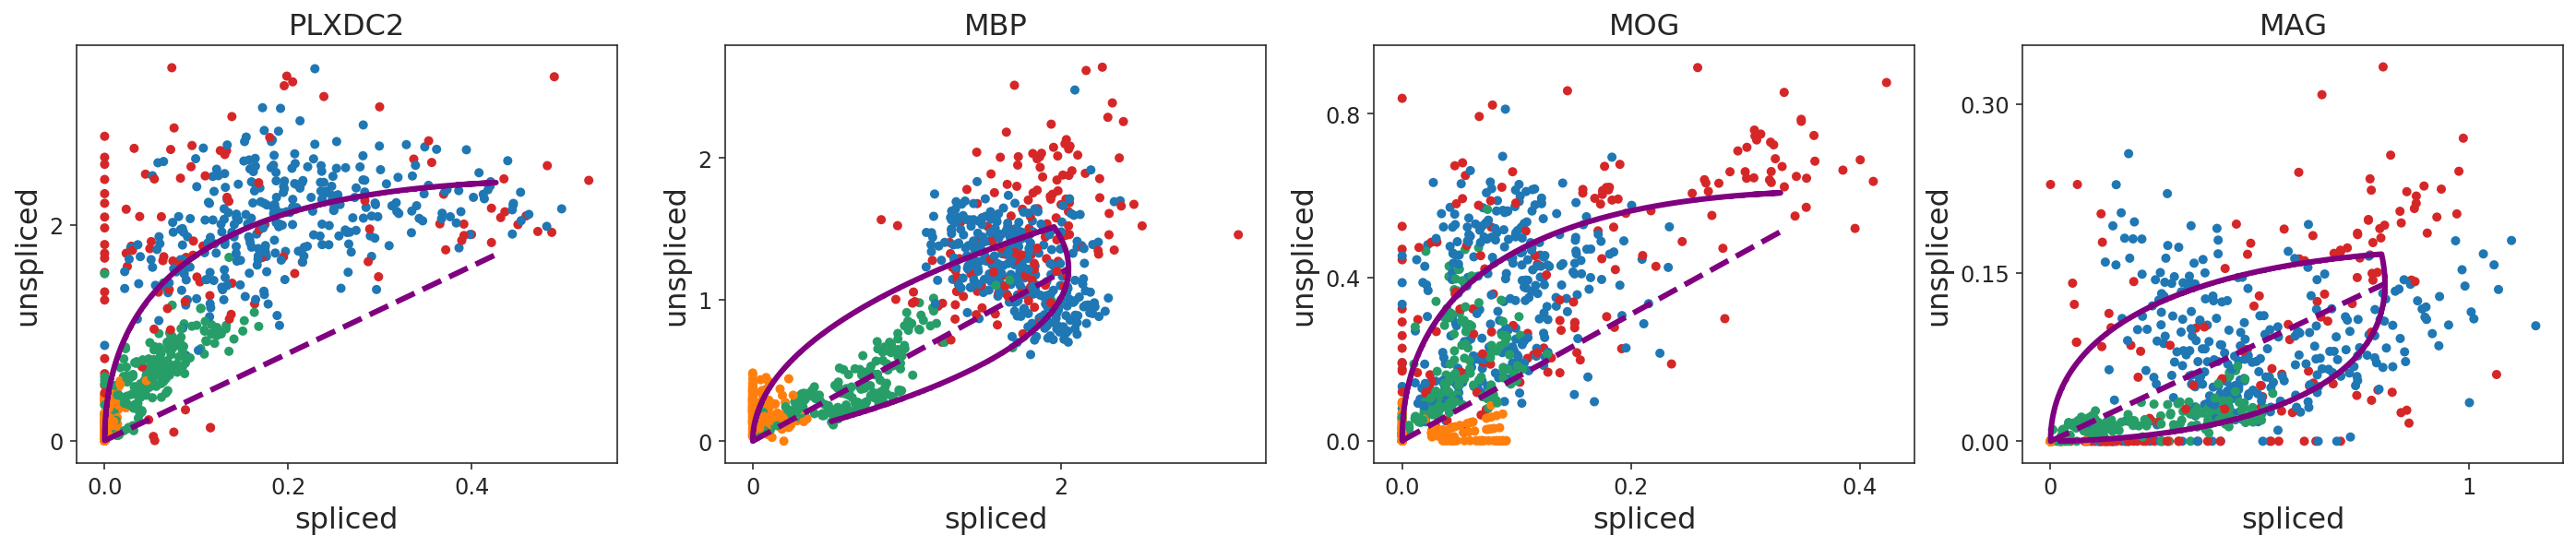

In [29]:
scv.pl.scatter(sca, basis=['PLXDC2', 'MBP', 'MOG', 'MAG'], fontsize=16, size=100, linewidth=3,
               frameon=True, legend_loc='none')

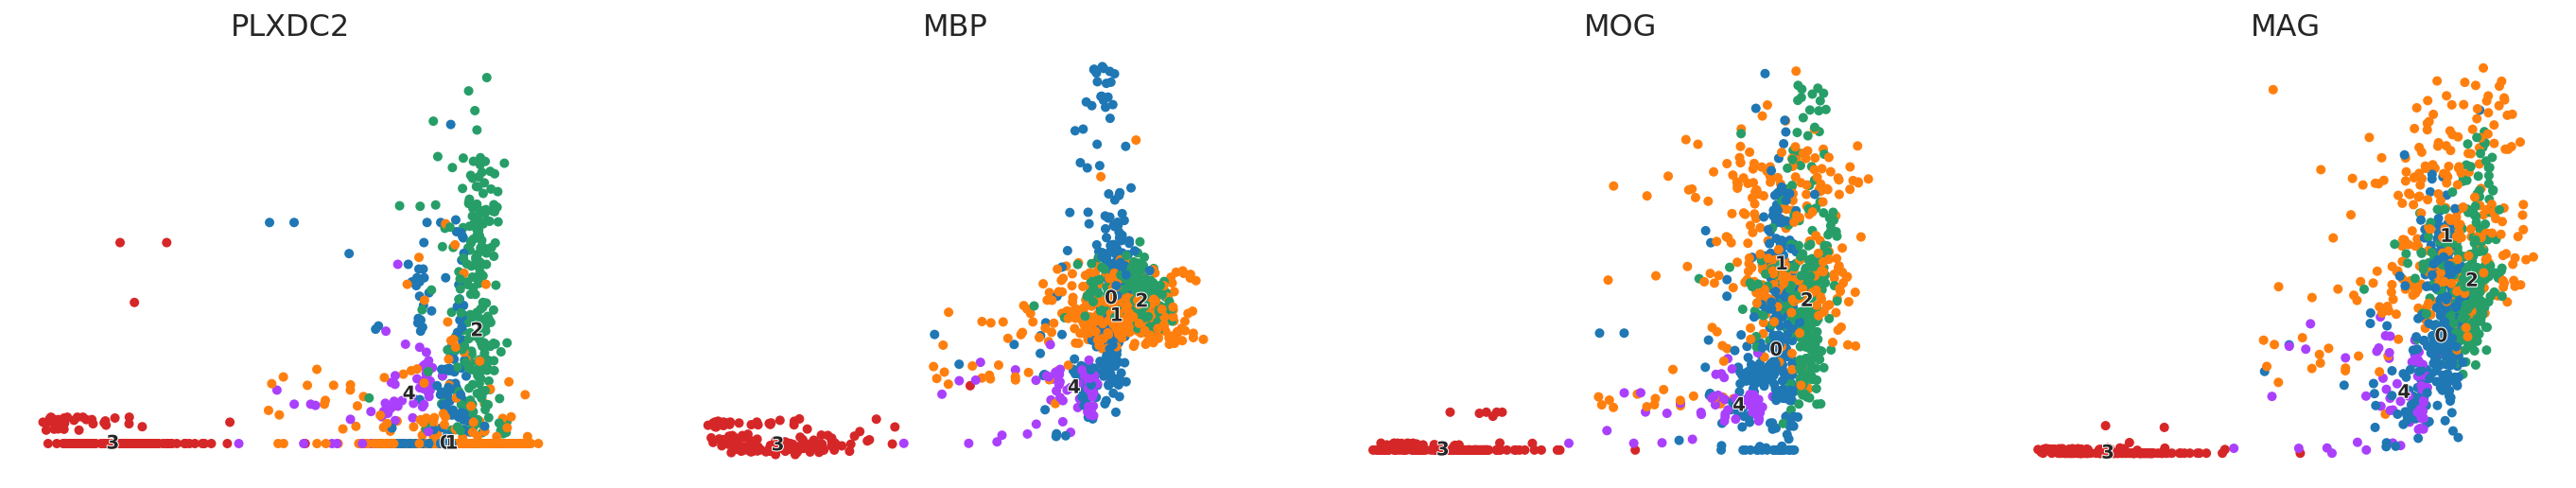

In [30]:
scv.pl.scatter(wt, x='latent_time', y=['PLXDC2', 'MBP', 'MOG', 'MAG'], fontsize=16, size=100,
               n_convolve=None, frameon=False)

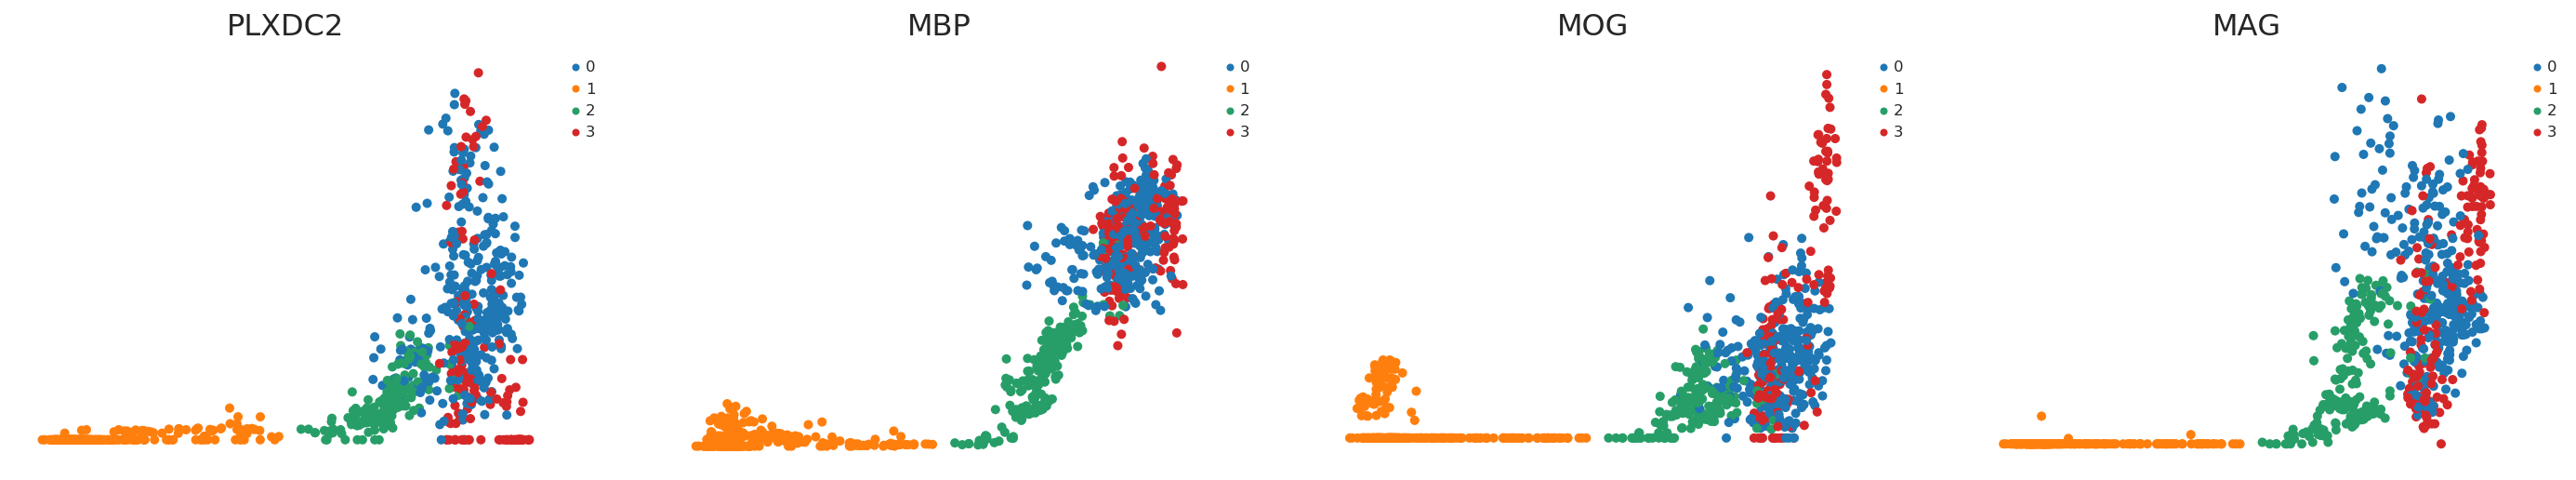

In [31]:
scv.pl.scatter(sca, x='latent_time', y=['PLXDC2', 'MBP', 'MOG', 'MAG'], fontsize=16, size=100,
               n_convolve=None, frameon=False)

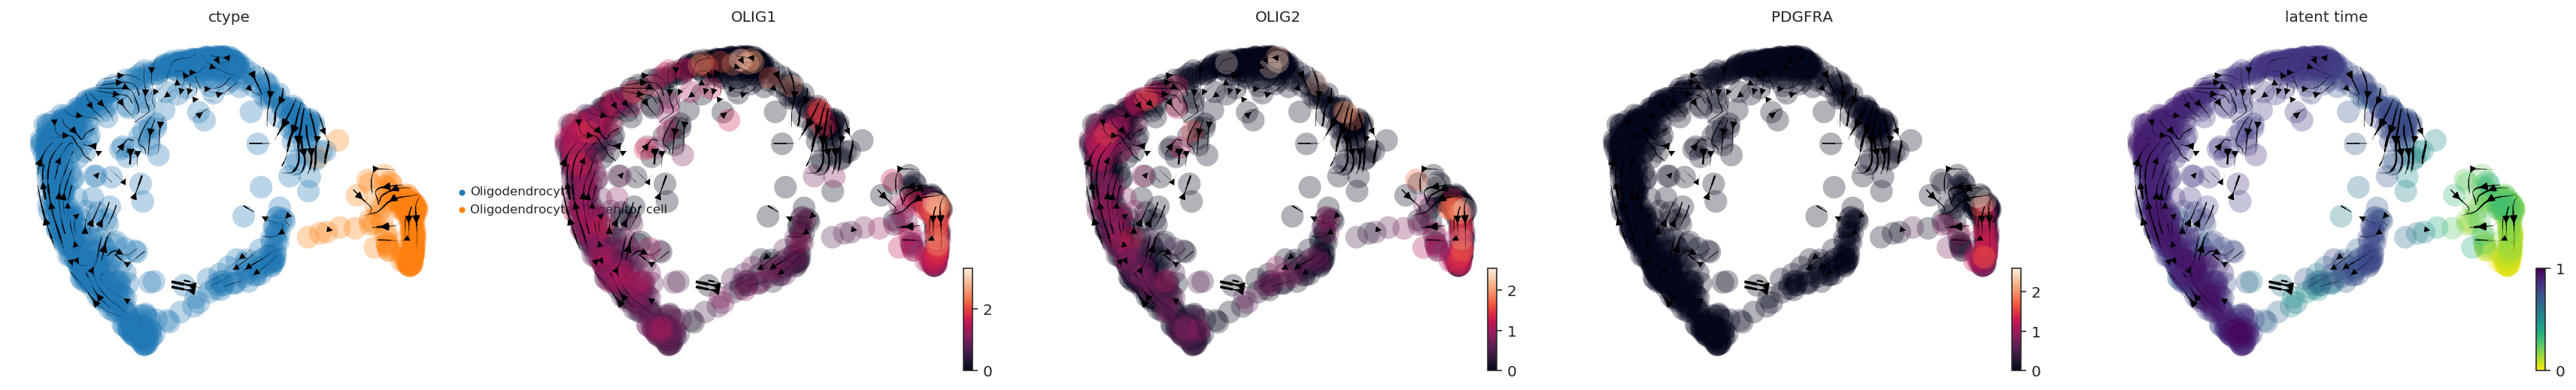

In [33]:
scv.pl.velocity_embedding_stream(wt, basis='phate', color=['ctype','OLIG1','OLIG2', 'PDGFRA', 'latent_time'], legend_loc='right_margin')

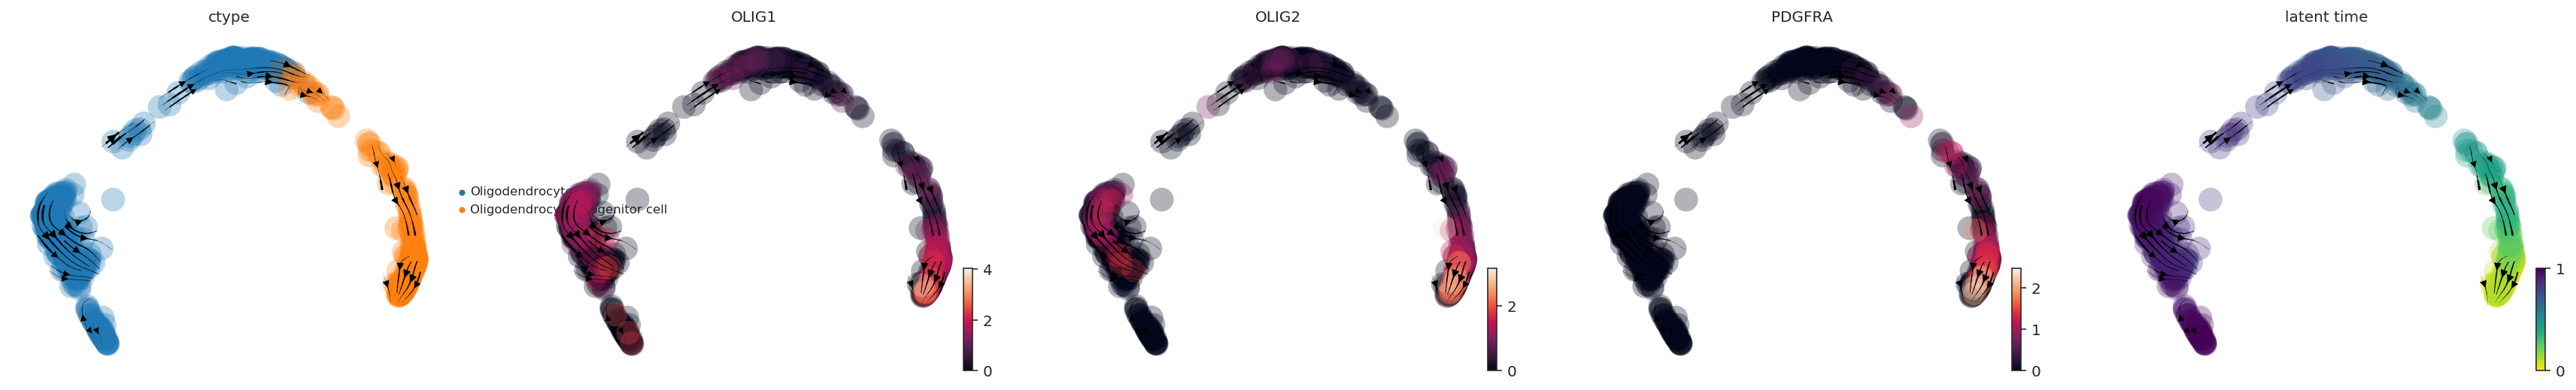

In [34]:
scv.pl.velocity_embedding_stream(sca, basis='phate', color=['ctype','OLIG1','OLIG2', 'PDGFRA', 'latent_time'], legend_loc='right_margin')